<a href="https://colab.research.google.com/github/CasCard/Machile-Learning-Project/blob/master/Predict_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [2]:
!pip install seaborn

In [0]:
import pathlib
from tensorflow.keras import layers
import seaborn as sns

In [4]:
dataset_path=keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

In [0]:
import pandas as pd


In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset=pd.read_csv(dataset_path,names=column_names,
                        na_values="?",comment="\t",
                        sep=" ",skipinitialspace=True)
dataset=raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset=dataset.dropna()

In [9]:
origin=dataset.pop('Origin')
dataset['USA']=(origin==1)*1.0
dataset['Europe']=(origin==2)*1.0
dataset['Japan']=(origin==3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [0]:
#Split the data into training and test set
train_dataset=dataset.sample(frac=0.8,random_state=0)
test_data=dataset.drop(train_dataset.index)

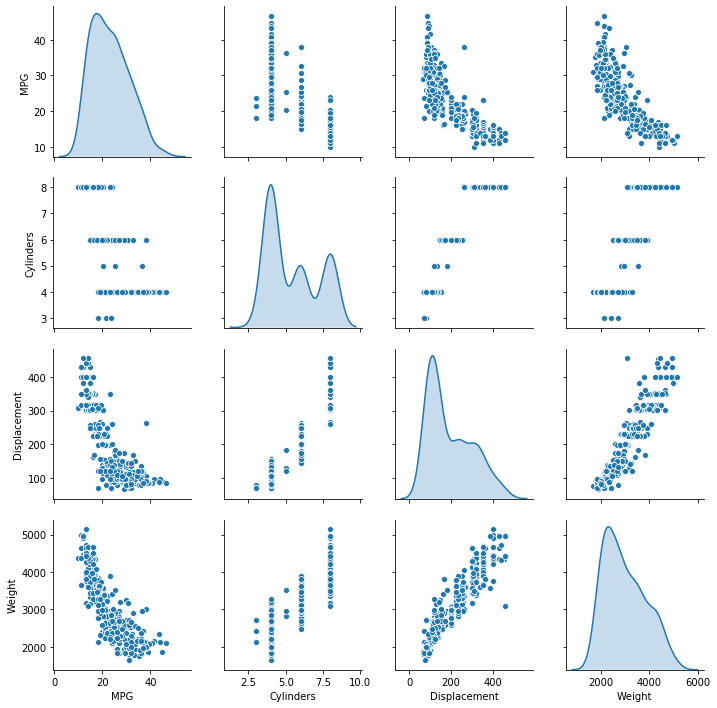

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [12]:
train_stats=train_dataset.describe()
train_stats.pop("MPG")
train_stats=train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
train_labels=train_dataset.pop('MPG')
test_labels=test_data.pop('MPG')

In [0]:
#Normalization of the datasets
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

normed_train_data=norm(train_dataset)
normed_test_data=norm(test_data)

In [0]:
def build_model():
  model=keras.Sequential([
                          layers.Dense(64,activation='relu',
                          input_shape=[len(train_dataset.keys())]),
                          layers.Dense(64,activation='relu'),
                          layers.Dense(1)
  ])
  optimizer=tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
  return model

In [0]:
model=build_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [20]:
example_batch=normed_train_data[:10]
example_result=model.predict(example_batch)
example_result

array([[ 0.06644151],
       [ 0.18160267],
       [-0.4055096 ],
       [ 0.04461481],
       [ 0.31747186],
       [ 0.04270177],
       [ 0.31987232],
       [ 0.02388305],
       [ 0.00463382],
       [ 0.6794605 ]], dtype=float32)

In [22]:
# Train the model
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 ==0:print('')
    print('.',end='')

EPOCHS=1000

history=model.fit(
    normed_train_data,train_labels,
    epochs=EPOCHS,validation_split=0.2,verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [23]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.312636,0.978784,2.312636,9.530625,2.366678,9.530625,995
996,2.380833,0.996949,2.380833,9.781260,2.414763,9.781260,996
997,2.359653,0.964348,2.359653,9.707702,2.434776,9.707702,997
998,2.318638,1.007041,2.318638,9.529516,2.408101,9.529516,998
999,2.328081,0.948134,2.328081,9.438655,2.328946,9.438655,999


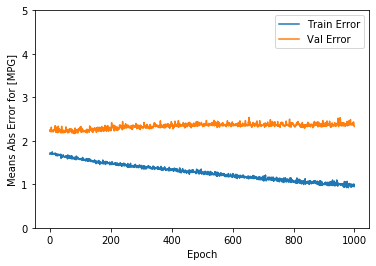

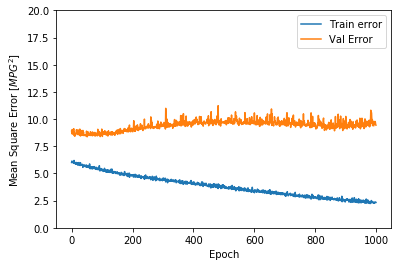

In [25]:
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Means Abs Error for [MPG]')
  plt.plot(hist['epoch'],hist['mae'],label='Train Error')
  plt.plot(hist['epoch'],hist['val_mae'],
           label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'],hist['mse'],
           label='Train error')
  plt.plot(hist['epoch'],hist['val_mse'],
           label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

In [26]:
model=build_model()

early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history=model.fit(normed_train_data,train_labels,epochs=EPOCHS,
                  validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])


....................................................................

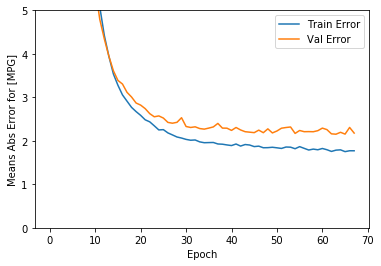

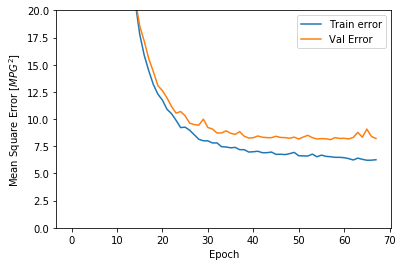

In [27]:
plot_history(history)

In [28]:
loss,mae,mse=model.evaluate(normed_test_data,test_labels,verbose=2)
print("Testing set Mean Abs Error:{:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.5836 - mae: 1.9145 - mse: 5.5836
Testing set Mean Abs Error: 1.91 MPG


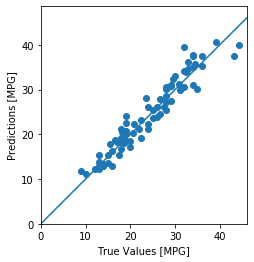

In [29]:
test_predictions=model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

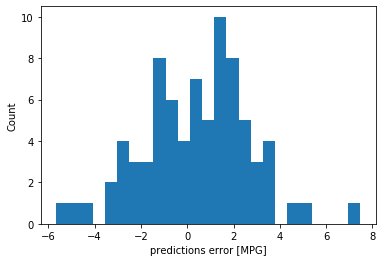

In [30]:
error=test_predictions-test_labels
plt.hist(error,bins=25)
plt.xlabel("predictions error [MPG]")
_ = plt.ylabel("Count")

Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
Early stopping is a useful technique to prevent overfitting.